In [1]:
include("../src/ising.jl")
using CairoMakie
using JLD2
import LsqFit as lsq
import PrettyTables as pt

## simple testing

### create functions to not repeat code

In [2]:
function autocorr_fit(t, p)
    return p[1] .* exp.(-t ./ abs(p[2]))
end

autocorr_fit (generic function with 1 method)

In [3]:
function plot_energy_mag(nrg, mag)
    fig = Figure(size = (1000, 400))
    ax1 = Axis(fig[1, 1], title = "Energy", xlabel = "Step", ylabel = "Energy")
    ax2 = Axis(fig[1, 2], title = "Magnetization", xlabel = "Step", ylabel = "Magnetization")
    lines!(ax1, nrg, color = :blue)
    lines!(ax2, abs.(mag), color = :red)
    return fig
end

plot_energy_mag (generic function with 1 method)

In [4]:
function plot_autocorr(nrg, N_Thermalize::Int=50_000, max_lag::Int=1_000)
    aco = autocorr(nrg[N_Thermalize:end], max_lag=max_lag)
    t = collect(1:max_lag)
    fit = lsq.curve_fit(autocorr_fit, t, aco, [1., 1.])
    print("Tau: ", abs(fit.param[2]))
    
    fig = Figure()
    ax = Axis(fig[1, 1])
    plot!(ax, t, aco, label="Energy Autocorrelation")
    lines!(ax, t, autocorr_fit(t, fit.param), label="Fit", color=:red)
    axislegend(ax)
    return fig
end

plot_autocorr (generic function with 3 methods)

### metropolis

In [5]:
grid_size = 10
T = 5.0
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=metropolis_step);

In [6]:
@time m_nrg, m_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=500_000, mc_algorithm=metropolis_step);

  0.043801 seconds (63 allocations: 7.661 MiB, 23.41% compilation time)


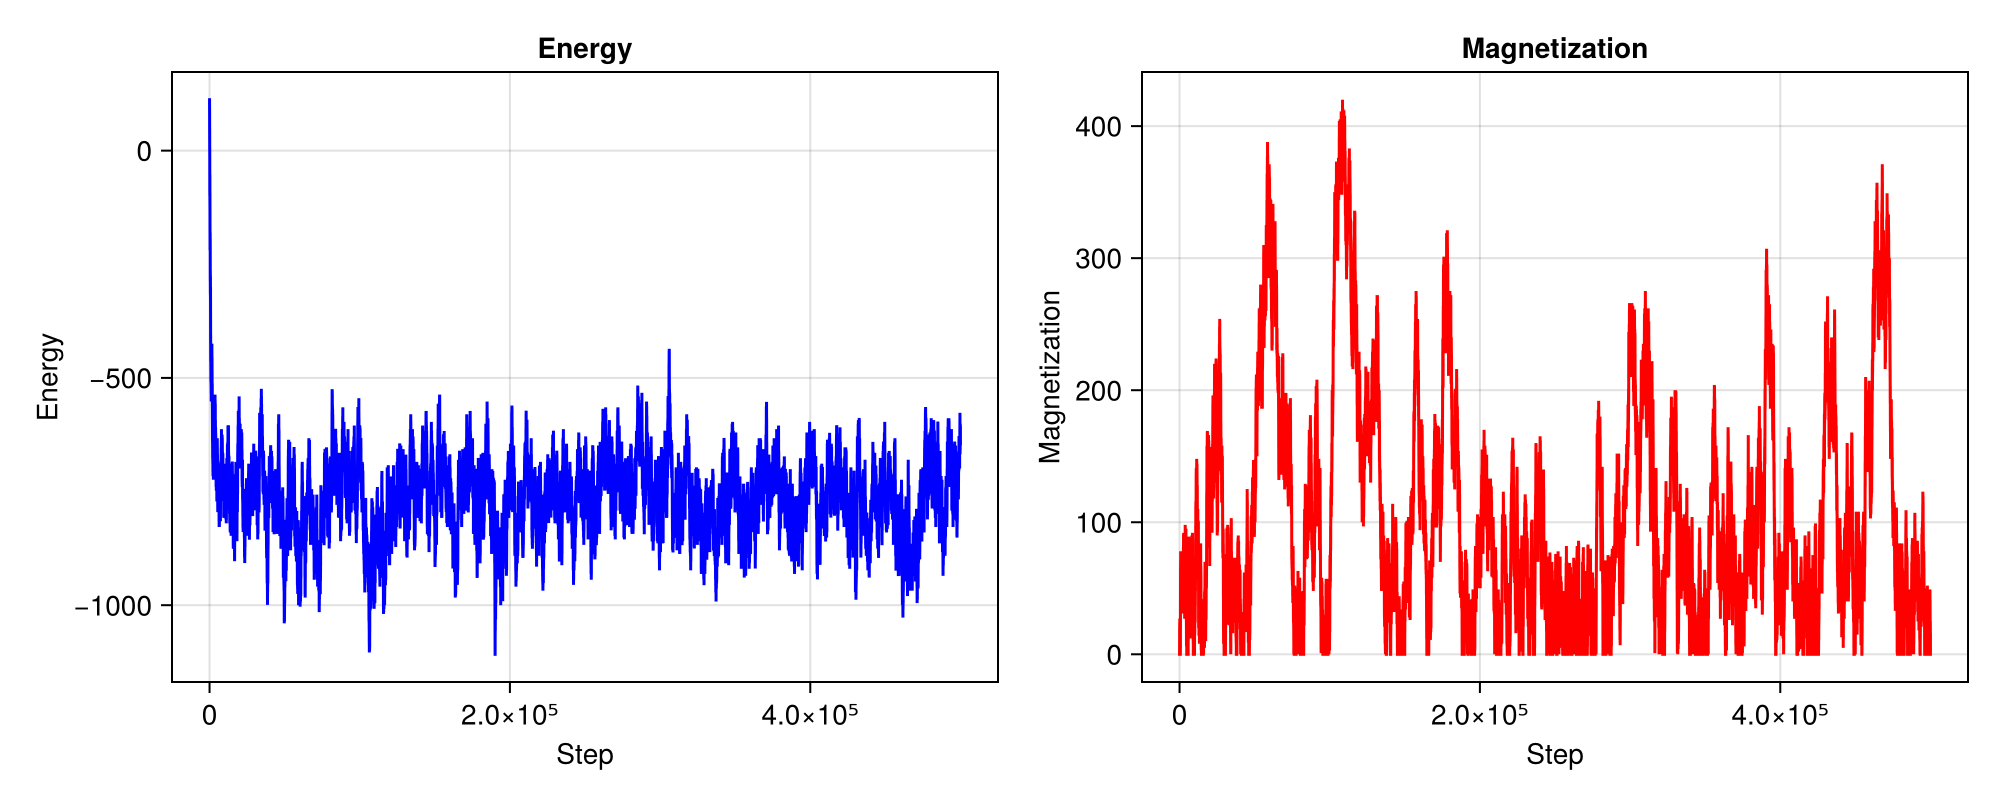

In [7]:
plot_energy_mag(m_nrg, m_mag)

Tau: 2272.9388895465013

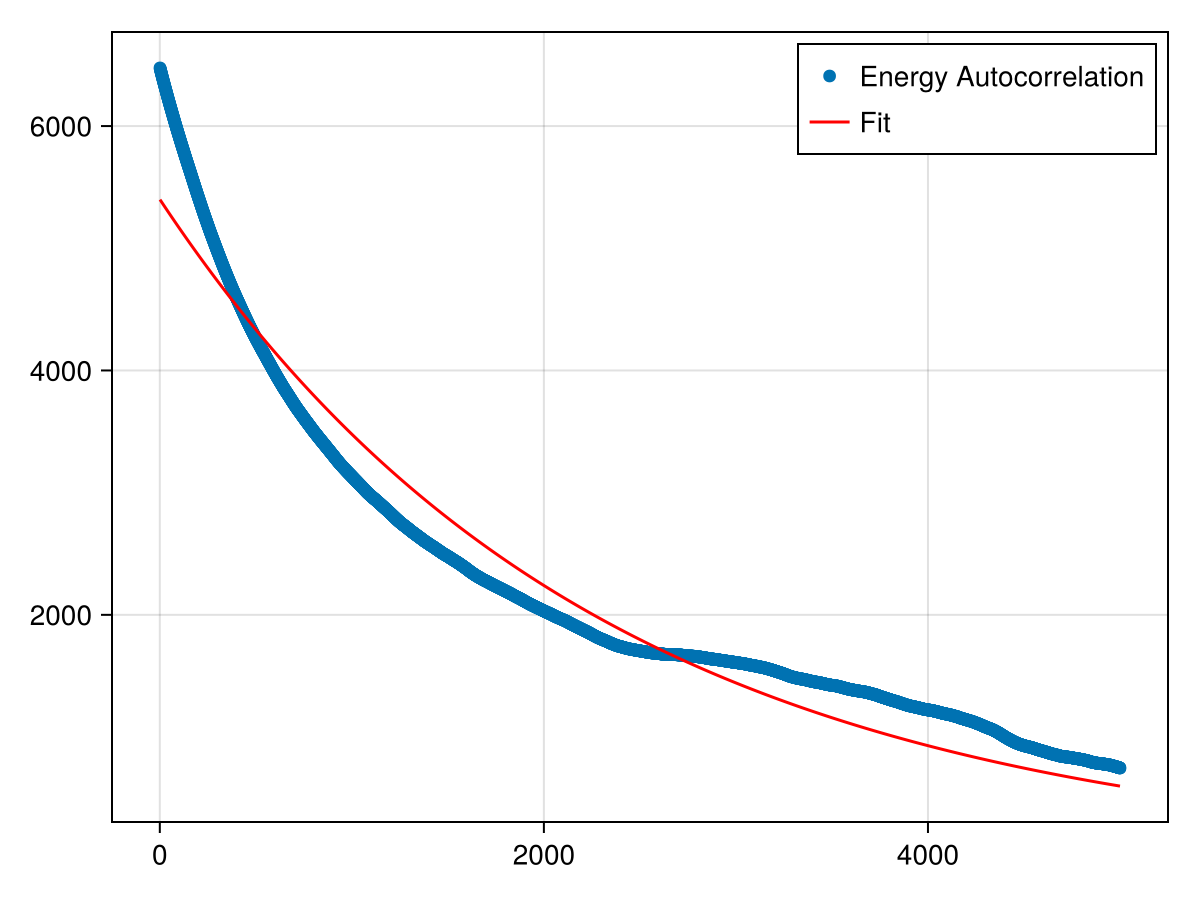

In [8]:
plot_autocorr(m_nrg, 50_000, 5_000)

### Wolff

In [9]:
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=wolff_step);

In [10]:
@time w_nrg, w_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=10_000, mc_algorithm=wolff_step)

  0.119547 seconds (448.02 k allocations: 96.927 MiB)


([4.0, 8.0, 4.0, -32.0, -40.0, -64.0, -64.0, -96.0, -116.0, -108.0  …  -732.0, -744.0, -748.0, -772.0, -772.0, -776.0, -876.0, -884.0, -848.0, -844.0], [-6.034, 1.9660000000000002, -0.03399999999999981, -24.034, -40.034, -52.034, -56.034, -72.03399999999999, -88.03399999999999, -86.03399999999999  …  -38.03399999999999, -24.033999999999992, -20.033999999999992, -124.03399999999999, -122.03399999999999, -124.03399999999999, 129.966, 135.966, 121.96600000000001, 123.96600000000001])

much less steps are needed to reach equilibrium. the runtime is slower but the number of steps isn't really comparable, because the wolff algorithm flips a lot more spins per step.

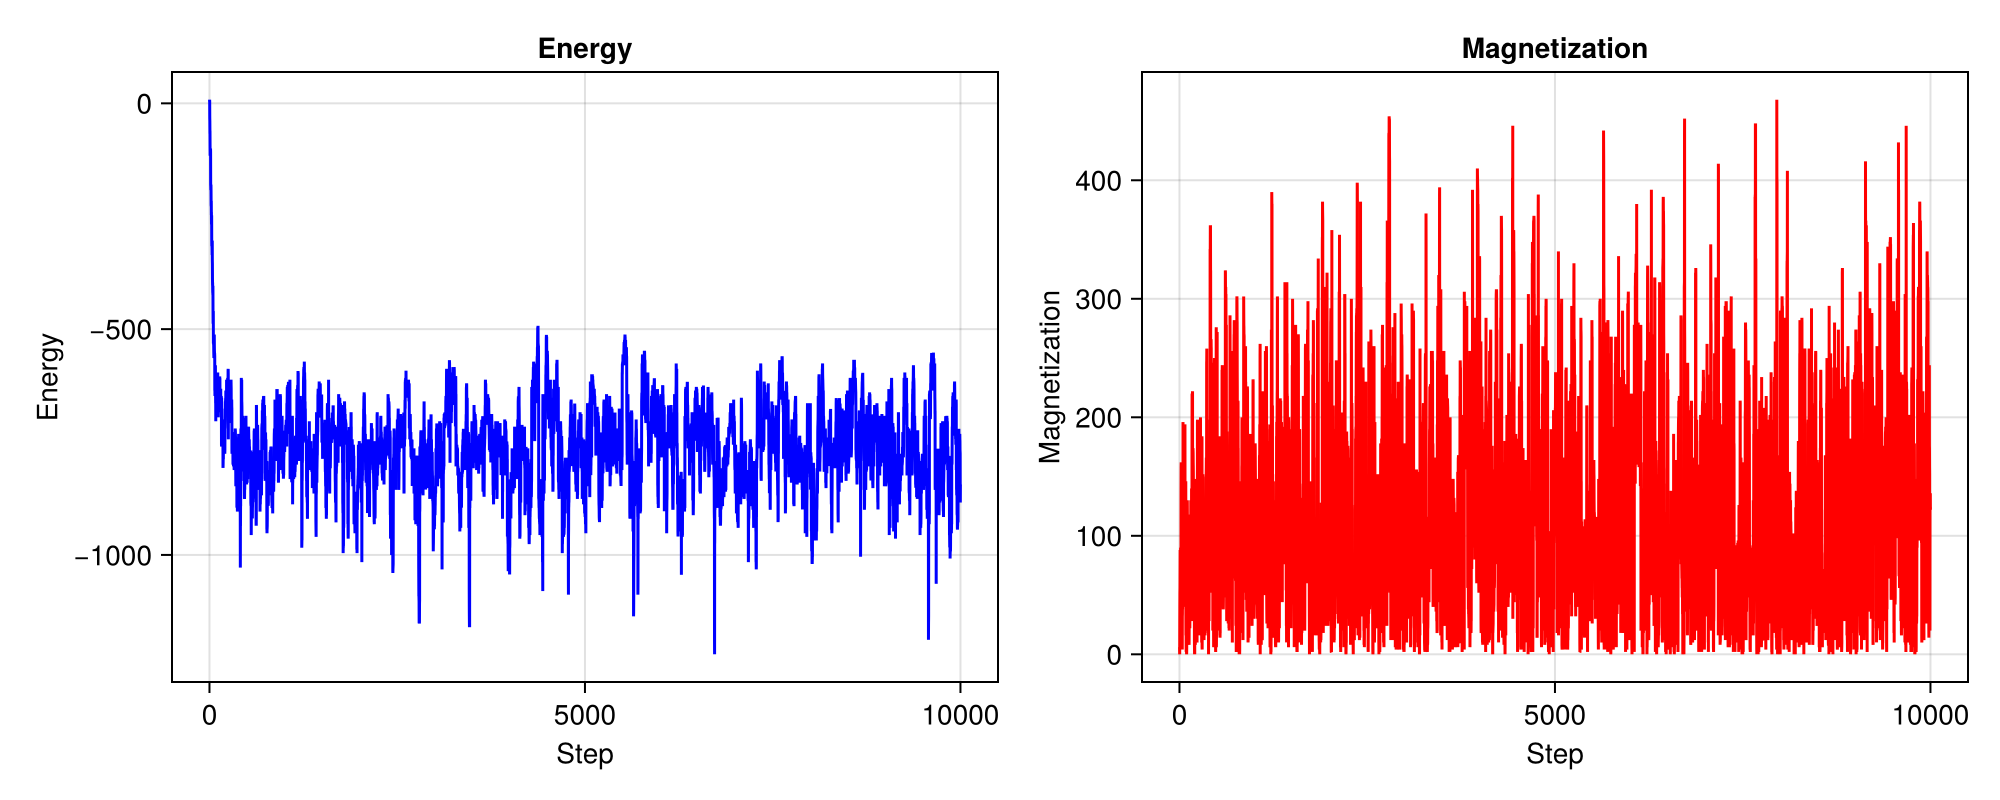

In [11]:
plot_energy_mag(w_nrg, w_mag)

Tau: 19.885979783583497

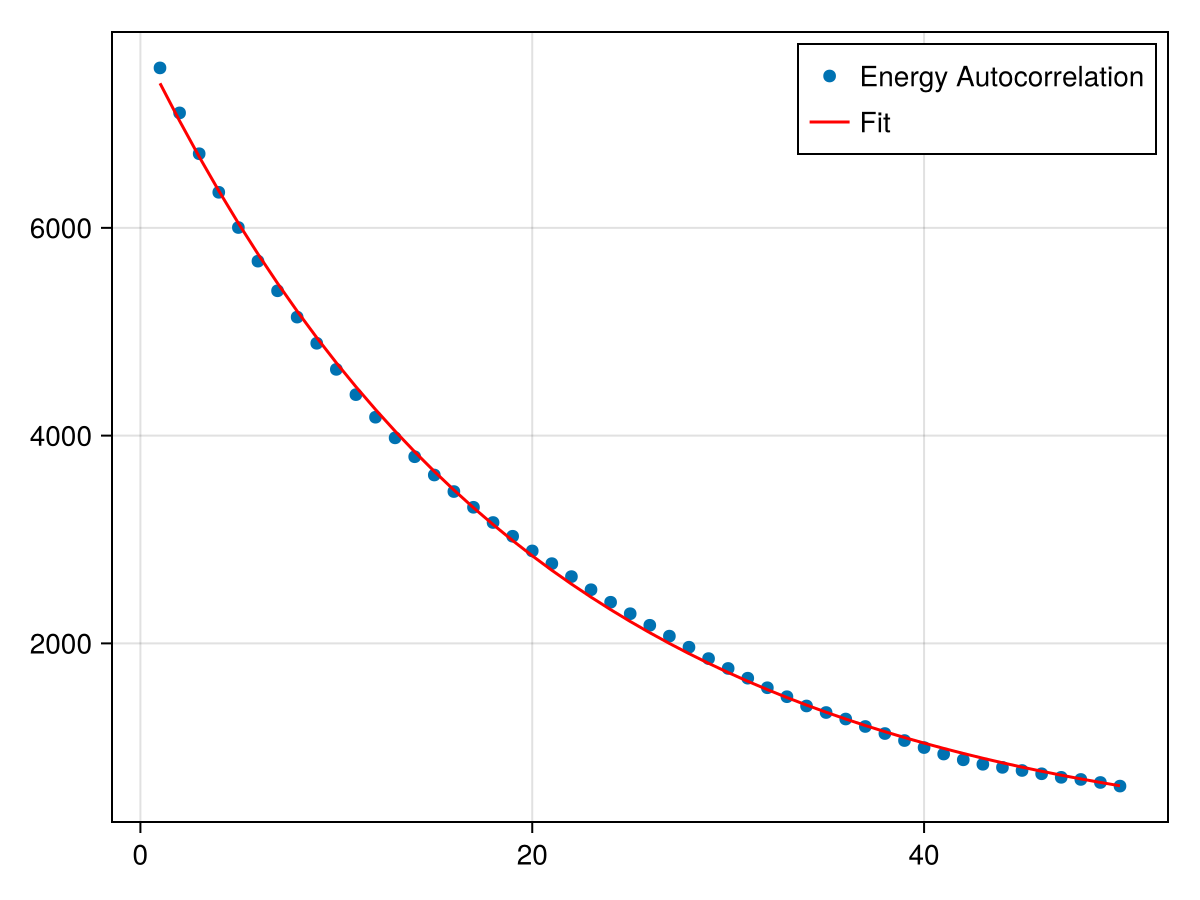

In [12]:
plot_autocorr(w_nrg, 1_000, 50)

the autocorrelation time is much smaller

## Fließbandarbeit 

In [13]:
linfit(x, p) = x .* p[1] .+ p[2]

function get_ac_time(energy; N_Thermalize::Int=50_000, max_lag::Int=1_000)
    ac = autocorr(energy[N_Thermalize:end], max_lag=max_lag)

    # if the autocorrelation gets negative, remove the values after that
    if any(ac .< 0)
        ac = ac[1:findfirst(ac .< 0)-1]
    end

    ac_log = log.(ac)
    time = collect(1:length(ac_log))

    fit = lsq.curve_fit(linfit, time, ac_log, [1., 1.])
    return 1/abs(fit.param[1])
end

function gather_times(;grid_size::Int=10, T::Float64=5., N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step)
    run_times = Vector{Float64}(undef, N_Tests)
    autocorr_times = Vector{Float64}(undef, N_Tests)
    for i in 1:N_Tests
        run_times[i]  = @elapsed energy, mag = simple_monte_carlo(grid_size=grid_size, T=T, N=N_Sweeps, mc_algorithm=mc_algorithm)
        autocorr_times[i] =  get_ac_time(energy; N_Thermalize=N_Thermalize, max_lag=max_lag)
    end
    mc_speed = N_Sweeps ./ (run_times .* autocorr_times)
    return mean(run_times), mean(autocorr_times), mean(mc_speed) 
end

gather_times (generic function with 1 method)

In [14]:
gather_times(grid_size=10, T=5., N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)

(0.0361948824, 2574.6277229962157, 5595.383328782114)

In [15]:
# multiple temperatures
function ensemble_times(grid_size::Int=10, temps::Array{Float64}=[3.51,4.51,5.51]; N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step) 
    run_times = Vector{Float64}(undef, length(temps))
    autocorr_times = Vector{Float64}(undef, length(temps))
    mc_speeds = Vector{Float64}(undef, length(temps))
    Threads.@threads for (i, T) in collect(enumerate(temps))
        run_times[i], autocorr_times[i], mc_speeds[i] = gather_times(grid_size=grid_size, T=T, N_Sweeps=N_Sweeps, N_Thermalize=N_Thermalize, max_lag=max_lag, N_Tests=N_Tests, mc_algorithm=mc_algorithm)
    end
    return run_times, autocorr_times, mc_speeds
end

function ensemble_times_table(temps::Vector{Float64}, grid_size::Int, run_times::Vector{Float64}, autocorr_times::Vector{Float64}, mc_speeds::Vector{Float64})
    grid_sizes = [grid_size for i in 1:length(temps)]
    data = hcat(temps, grid_sizes, run_times, autocorr_times, mc_speeds)
    return pt.pretty_table(data , header=["Temperature", "Grid Size", "Run Time", "Autocorrelation Time", "MC Speed"])
end

# multiple grid sizes

function ensemble_times(grid_sizes::Array{Int}=[8, 10, 12], temp::Float64=5.; N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step) 
    run_times = Vector{Float64}(undef, length(grid_sizes))
    autocorr_times = Vector{Float64}(undef, length(grid_sizes))
    mc_speeds = Vector{Float64}(undef, length(grid_sizes))
    Threads.@threads for (i, grid_size) in collect(enumerate(grid_sizes))
        run_times[i], autocorr_times[i], mc_speeds[i] = gather_times(grid_size=grid_size, T=T, N_Sweeps=N_Sweeps, N_Thermalize=N_Thermalize, max_lag=max_lag, N_Tests=N_Tests, mc_algorithm=mc_algorithm)
    end
    return run_times, autocorr_times, mc_speeds
end

function ensemble_times_table(temp::Float64, grid_sizes::Vector{Int}, run_times::Vector{Float64}, autocorr_times::Vector{Float64}, mc_speeds::Vector{Float64})
    temps = [temp for i in 1:length(grid_sizes)]
    data = hcat(temps, grid_sizes, run_times, autocorr_times, mc_speeds)
    return pt.pretty_table(data, header=["Temperature", "Grid Size", "Run Time", "Autocorrelation Time", "MC Speed"])
end

ensemble_times_table (generic function with 2 methods)

### Temperatures

In [16]:
temps = [3, 3.5, 4, 4.5, 5, 5.5, 6]
grid_size = 10;

In [17]:
# metropolis
ensemble_times_table(temps, grid_size, ensemble_times(grid_size, temps, N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         3.0 │      10.0 │ 0.0605942 │              1396.68 │  6609.27 │
│         3.5 │      10.0 │ 0.0538815 │              2281.09 │  4686.82 │
│         4.0 │      10.0 │  0.101656 │              4057.88 │  1612.37 │
│         4.5 │      10.0 │ 0.0581931 │              10391.4 │  925.408 │
│         5.0 │      10.0 │ 0.0715876 │              2757.91 │  3028.29 │
│         5.5 │      10.0 │  0.100372 │              1346.82 │  4511.46 │
│         6.0 │      10.0 │ 0.0518988 │               1264.9 │  8866.14 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘


In [18]:
# wolff
ensemble_times_table(temps, grid_size, ensemble_times(grid_size, temps, N_Sweeps=10_000, N_Thermalize=1_000, max_lag=50, N_Tests=5, mc_algorithm=wolff_step)...)

┌─────────────┬───────────┬──────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │ Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼──────────┼──────────────────────┼──────────┤
│         3.0 │      10.0 │  6.55633 │             0.778953 │  2295.03 │
│         3.5 │      10.0 │   6.2757 │              1.25833 │  1833.57 │
│         4.0 │      10.0 │  5.02541 │              1.69374 │  1308.85 │
│         4.5 │      10.0 │  2.10544 │              11.2172 │  646.452 │
│         5.0 │      10.0 │ 0.254139 │              24.1911 │  1972.45 │
│         5.5 │      10.0 │ 0.177397 │              43.1692 │  2029.49 │
│         6.0 │      10.0 │ 0.178944 │              50.0913 │  1824.98 │
└─────────────┴───────────┴──────────┴──────────────────────┴──────────┘


### Lattice sizes

In [19]:
temp = 5.0
grid_sizes = [5, 8, 10, 12, 15]

5-element Vector{Int64}:
  5
  8
 10
 12
 15

In [20]:
# metropolis
ensemble_times_table(temp, grid_sizes, ensemble_times(grid_sizes, temp, N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         5.0 │       5.0 │ 0.0693708 │              924.997 │  11226.2 │
│         5.0 │       8.0 │ 0.0580525 │               2495.7 │   3966.4 │
│         5.0 │      10.0 │ 0.0866469 │              2937.38 │  2602.43 │
│         5.0 │      12.0 │ 0.0766432 │              3798.62 │  2559.26 │
│         5.0 │      15.0 │ 0.0810119 │              5383.93 │   1744.4 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘


In [21]:
# wolff
ensemble_times_table(temp, grid_sizes, ensemble_times(grid_sizes, temp, N_Sweeps=10_000, N_Thermalize=1_000, max_lag=50, N_Tests=5, mc_algorithm=wolff_step)...)

┌─────────────┬───────────┬──────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │ Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼──────────┼──────────────────────┼──────────┤
│         5.0 │       5.0 │ 0.147322 │              4.19547 │  19868.7 │
│         5.0 │       8.0 │  0.23433 │              13.6956 │  3479.97 │
│         5.0 │      10.0 │  0.20119 │              23.5328 │  2465.91 │
│         5.0 │      12.0 │ 0.354611 │              38.2274 │  827.394 │
│         5.0 │      15.0 │ 0.360365 │              57.8097 │  566.701 │
└─────────────┴───────────┴──────────┴──────────────────────┴──────────┘
